In [2]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install GPy
import pandas as pd
import zipfile
import urllib.request
import GPy
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from torch.optim.sgd import SGD
from sklearn.model_selection import KFold

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from google.colab import files
%config InlineBackend.figure_format = 'svg'

In [3]:
torch.cuda.device(0)
torch.cuda.get_device_name(torch.cuda.current_device())

'Tesla T4'

In [0]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

In [0]:
class Langevin_SGD(Optimizer):

    def __init__(self, params, lr, weight_decay=0, nesterov=False):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, weight_decay=weight_decay)
        
        super(Langevin_SGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def step(self, closure=None):
        
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            
            weight_decay = group['weight_decay']
            
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                if len(p.shape) == 1 and p.shape[0] == 1:
                    p.data.add_(-group['lr'], d_p)
                    
                else:
                    if weight_decay != 0:
                        d_p.add_(weight_decay, p.data)

                    unit_noise = Variable(p.data.new(p.size()).normal_())

                    p.data.add_(-group['lr'], 0.5*d_p + unit_noise/group['lr']**0.5)

        return loss

In [0]:
def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma)
    
    return - (log_coeff + exponent).sum()


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()

In [0]:
class Langevin_Layer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Langevin_Layer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.weights = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.01, 0.01))
        self.biases = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.01, 0.01))
        
    def forward(self, x):
        
        return torch.mm(x, self.weights) + self.biases

In [0]:
class Langevin_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units):
        super(Langevin_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer
        self.layer1 = Langevin_Layer(input_dim, num_units)
        self.layer2 = Langevin_Layer(num_units, 2*output_dim)
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
    
    def forward(self, x):
        
        x = x.view(-1, self.input_dim)
        
        x = self.layer1(x)
        x = self.activation(x)
        
        x = self.layer2(x)
        
        return x

In [0]:
class Langevin_Wrapper:
    def __init__(self, network, learn_rate, batch_size, no_batches, weight_decay):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = network
        self.network.cuda()
        
        self.optimizer = Langevin_SGD(self.network.parameters(), lr=self.learn_rate, weight_decay=weight_decay)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        
        output = self.network(x)
        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)
        
        loss.backward()
        self.optimizer.step()

        return loss
    
    
    def test_loss(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        output = self.network(x)
        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)

        return loss

In [0]:
def eval_ensemble(x, y, ensemble):
    
    x, y = to_variable(var=(x, y), cuda=True)
        
    means, stds = [], []
    for net in ensemble:
        output = net(x)
        means.append(output[:, :1, None])
        stds.append(output[:, 1:, None].exp())
            
    means, stds = torch.cat(means, 2), torch.cat(stds, 2)
    mean = means.mean(dim=2)
    std = (means.var(dim=2) + stds.mean(dim=2)**2)**0.5
    loss = log_gaussian_loss(mean, y, std, 1)/len(x)
    
    rmse = ((mean - y)**2).mean()**0.5

    return loss, rmse

In [11]:
np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis=0)


k = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=lengthscale)
C = k.K(x, x) + np.eye(no_points)*(x + 2)**2*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_train = y[75:325]


best_net, best_loss = None, float('inf')
num_nets, nets, losses = 50, [], []
mix_epochs, burnin_epochs = 100, 1000
num_epochs = mix_epochs*num_nets + burnin_epochs + 1

batch_size, nb_train = len(x_train), len(x_train)

net = Langevin_Wrapper(network=Langevin_Model(input_dim=1, output_dim=1, num_units=200),
                       learn_rate=1e-4, batch_size=batch_size, no_batches=1, weight_decay=20)

for i in range(num_epochs):
    
    loss = net.fit(x_train, y_train)
    
    if i % mix_epochs == 0:
        print('Epoch: %4d, Train loss = %8.3f' % (i, loss.cpu().data.numpy()))
        
    if i % 100 == 0 and i > burnin_epochs: nets.append(copy.deepcopy(net.network))

Epoch:    0, Train loss =  348.689
Epoch:  100, Train loss =  164.954
Epoch:  200, Train loss =  105.301
Epoch:  300, Train loss =   90.521
Epoch:  400, Train loss =   64.924
Epoch:  500, Train loss =   55.467
Epoch:  600, Train loss =   47.499
Epoch:  700, Train loss =   29.145
Epoch:  800, Train loss =    7.563
Epoch:  900, Train loss =   27.644
Epoch: 1000, Train loss =    6.976
Epoch: 1100, Train loss =   -3.997
Epoch: 1200, Train loss =  -16.176
Epoch: 1300, Train loss =    8.504
Epoch: 1400, Train loss =   15.614
Epoch: 1500, Train loss =  -25.763
Epoch: 1600, Train loss =   41.449
Epoch: 1700, Train loss =   -6.983
Epoch: 1800, Train loss =  -15.342
Epoch: 1900, Train loss =  -15.076
Epoch: 2000, Train loss =    1.618
Epoch: 2100, Train loss =  -40.463
Epoch: 2200, Train loss =  -32.578
Epoch: 2300, Train loss =   -6.959
Epoch: 2400, Train loss =   31.176
Epoch: 2500, Train loss =  -18.083
Epoch: 2600, Train loss =   -9.308
Epoch: 2700, Train loss =  -27.050
Epoch: 2800, Train l

Using 50 networks for prediction


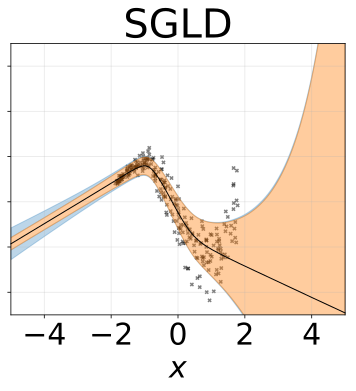

In [12]:
print("Using %d networks for prediction" % len(nets))
samples = []
noises = []
for network in nets:
    preds = network.forward(torch.linspace(-5, 5, 200).cuda()).cpu().data.numpy()
    samples.append(preds[:, 0])
    noises.append(np.exp(preds[:, 1]))
    
samples = np.array(samples)
means = (samples.mean(axis = 0)).reshape(-1)

noises = np.array(noises)
aleatoric = (noises**2).mean(axis = 0)**0.5
epistemic = samples.var(axis = 0)**0.5
total_unc = (aleatoric**2 + epistemic**2)**0.5

c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize = (6, 5))
plt.style.use('default')
plt.scatter(x_train, y_train, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(np.linspace(-5, 5, 200), means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
plt.fill_between(np.linspace(-5, 5, 200), means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
plt.fill_between(np.linspace(-5, 5, 200), means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = 'Aleatoric')
plt.plot(np.linspace(-5, 5, 200), means, color = 'black', linewidth = 1)
plt.xlim([-5, 5])
plt.ylim([-5, 7])
plt.xlabel('$x$', fontsize=30)
plt.title('SGLD', fontsize=40)
plt.tick_params(labelsize=30)
plt.xticks(np.arange(-4, 5, 2))
plt.yticks(np.arange(-4, 7, 2))
plt.gca().set_yticklabels([])
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.savefig('sgld_hetero.pdf', bbox_inches = 'tight')

files.download("sgld_hetero.pdf")

plt.show()

# UCI dataset

In [0]:
class Langevin_Model_UCI(nn.Module):
    def __init__(self, input_dim, output_dim, num_units):
        super(Langevin_Model_UCI, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer
        self.layer1 = Langevin_Layer(input_dim, num_units)
        self.layer2 = Langevin_Layer(num_units, num_units)
        self.layer3 = Langevin_Layer(num_units, 2*output_dim)
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
    
    def forward(self, x):
        
        x = x.view(-1, self.input_dim)
        
        x = self.layer1(x)
        x = self.activation(x)
        
        x = self.layer2(x)
        x = self.activation(x)
        
        x = self.layer3(x)
        
        return x


def train_mc_dropout(data, n_splits, burn_in, mix_time, num_nets, num_units, learn_rate, weight_decay, log_every):
    
    kf = KFold(n_splits=n_splits)
    in_dim = data.shape[1] - 1
    train_logliks, test_logliks = [], []
    train_rmses, test_rmses = [], []

    for j, idx in enumerate(kf.split(data)):
        print('FOLD %d:' % j)
        train_index, test_index = idx

        x_train, y_train = data[train_index, :in_dim], data[train_index, in_dim:]
        x_test, y_test = data[test_index, :in_dim], data[test_index, in_dim:]

        x_means, x_stds = x_train.mean(axis = 0), x_train.var(axis = 0)**0.5
        y_means, y_stds = y_train.mean(axis = 0), y_train.var(axis = 0)**0.5

        x_train = (x_train - x_means)/x_stds
        y_train = (y_train - y_means)/y_stds

        x_test = (x_test - x_means)/x_stds
        y_test = (y_test - y_means)/y_stds

        net = Langevin_Wrapper(network=Langevin_Model_UCI(input_dim=in_dim, output_dim=1, num_units=num_units),
                               learn_rate=learn_rate, batch_size=batch_size, no_batches=1, weight_decay=weight_decay)

        nets, losses = [], []
        num_epochs = burn_in + mix_time*num_nets + 1
        fit_loss_train = np.zeros(num_epochs)

        for i in range(num_epochs):
            loss = net.fit(x_train, y_train)

            if i % mix_time == 0 and i > burn_in:
                nets.append(copy.deepcopy(net.network))
                
            if i % log_every == 0 or i == num_epochs - 1:
                test_loss = net.test_loss(x_test, y_test).cpu().data.numpy()

                if len(nets) > 10: ensemble_loss, rmse = eval_ensemble(x_test, y_test, nets)
                else: ensemble_loss, rmse = float('nan'), float('nan')

                print('Epoch: %4d, Train loss: %6.3f Test loss: %6.3f Ensemble loss: %6.3f RMSE: %.3f Num. networks: %2d' %
                      (i, loss.cpu().data.numpy()/len(x_train), test_loss/len(x_test), ensemble_loss, rmse*y_stds[0], len(nets)))


        train_loss, train_rmse = eval_ensemble(x_train, y_train, nets)
        test_loss, test_rmse = eval_ensemble(x_test, y_test, nets)

        train_logliks.append(-(train_loss.cpu().data.numpy() + np.log(y_stds)[0]))
        test_logliks.append(-(test_loss.cpu().data.numpy() + np.log(y_stds)[0]))

        train_rmses.append(y_stds[0]*train_rmse.cpu().data.numpy())
        test_rmses.append(y_stds[0]*test_rmse.cpu().data.numpy())


    print('Train log. lik. = %6.3f +/- %6.3f' % (np.array(train_logliks).mean(), np.array(train_logliks).var()**0.5))
    print('Test  log. lik. = %6.3f +/- %6.3f' % (np.array(test_logliks).mean(), np.array(test_logliks).var()**0.5))
    print('Train RMSE      = %6.3f +/- %6.3f' % (np.array(train_rmses).mean(), np.array(train_rmses).var()**0.5))
    print('Test  RMSE      = %6.3f +/- %6.3f' % (np.array(test_rmses).mean(), np.array(test_rmses).var()**0.5))
    
    return nets

# Housing dataset

In [81]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data" --no-check-certificate 
data = pd.read_csv('housing.data', header=0, delimiter="\s+").values
data = data[np.random.permutation(np.arange(len(data)))]

--2019-05-17 19:03:50--  https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49082 (48K) [application/x-httpd-php]
Saving to: ‘housing.data.11’

housing.data.11     100%[===================>]  47.93K   170KB/s    in 0.3s    

2019-05-17 19:03:50 (170 KB/s) - ‘housing.data.11’ saved [49082/49082]



In [82]:
ensemble = train_mc_dropout(data=data, n_splits=10, burn_in=3000, mix_time=100, num_nets=20,
                            num_units=100, learn_rate=1e-2/len(data), weight_decay=1, log_every=500)

FOLD 0:
Epoch:    0, Train loss:  0.500 Test loss:  0.564 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch:  500, Train loss: -0.276 Test loss: -0.331 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 1000, Train loss: -0.766 Test loss: -0.717 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 1500, Train loss: -0.790 Test loss: -0.305 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 2000, Train loss: -0.770 Test loss: -0.786 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 2500, Train loss:  0.045 Test loss: -0.345 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 3000, Train loss: -0.632 Test loss: -0.590 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 3500, Train loss: -0.787 Test loss: -0.366 Ensemble loss:    nan RMSE: nan Num. networks:  5
Epoch: 4000, Train loss: -0.530 Test loss: -0.286 Ensemble loss:    nan RMSE: nan Num. networks: 10
Epoch: 4500, Train loss: -0.546 Test loss: -0.273 Ensemble loss: -0.625 RMSE: 2.828 Num. net

# Concrete compressive dataset

In [83]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls" --no-check-certificate
data = pd.read_excel('Concrete_Data.xls', header=0, delimiter="\s+").values
data = data[np.random.permutation(np.arange(len(data)))]

--2019-05-17 19:05:12--  https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124928 (122K) [application/x-httpd-php]
Saving to: ‘Concrete_Data.xls.3’

Concrete_Data.xls.3 100%[===================>] 122.00K   290KB/s    in 0.4s    

2019-05-17 19:05:13 (290 KB/s) - ‘Concrete_Data.xls.3’ saved [124928/124928]



In [84]:
ensemble = train_mc_dropout(data=data, n_splits=10, burn_in=3000, mix_time=100, num_nets=20,
                            num_units=200, learn_rate=1e-1/len(data), weight_decay=100, log_every=500)

FOLD 0:
Epoch:    0, Train loss:  0.500 Test loss:  0.489 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch:  500, Train loss: -0.022 Test loss:  0.103 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 1000, Train loss: -0.390 Test loss: -0.371 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 1500, Train loss:  0.317 Test loss: -0.043 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 2000, Train loss: -0.407 Test loss: -0.327 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 2500, Train loss: -0.380 Test loss: -0.333 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 3000, Train loss: -0.322 Test loss: -0.205 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 3500, Train loss: -0.345 Test loss: -0.295 Ensemble loss:    nan RMSE: nan Num. networks:  5
Epoch: 4000, Train loss: -0.183 Test loss: -0.205 Ensemble loss:    nan RMSE: nan Num. networks: 10
Epoch: 4500, Train loss: -0.342 Test loss: -0.347 Ensemble loss: -0.278 RMSE: 7.568 Num. net

# Energy efficiency dataset

In [15]:
np.random.seed(0)
!wget "http://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx" --no-check-certificate
data = pd.read_excel('ENB2012_data.xlsx', header=0, delimiter="\s+").values
data = data[np.random.permutation(np.arange(len(data)))]
data.shape

--2019-05-17 22:23:41--  http://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76189 (74K) [application/x-httpd-php]
Saving to: ‘ENB2012_data.xlsx.2’

ENB2012_data.xlsx.2 100%[===================>]  74.40K   233KB/s    in 0.3s    

2019-05-17 22:23:42 (233 KB/s) - ‘ENB2012_data.xlsx.2’ saved [76189/76189]



(768, 10)

In [16]:
ensemble = train_mc_dropout(data=data, n_splits=10, burn_in=3000, mix_time=100, num_nets=20,
                            num_units=200, learn_rate=1e-1/len(data), weight_decay=100, log_every=500)

FOLD 0:
Epoch:    0, Train loss:  0.500 Test loss:  0.549 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch:  500, Train loss:  0.005 Test loss: -0.321 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 1000, Train loss: -0.867 Test loss: -0.902 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 1500, Train loss: -0.846 Test loss:  0.741 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 2000, Train loss:  1.190 Test loss: -0.036 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 2500, Train loss:  0.085 Test loss:  1.299 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 3000, Train loss: -0.531 Test loss: -0.558 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 3500, Train loss:  2.104 Test loss:  0.251 Ensemble loss:    nan RMSE: nan Num. networks:  5
Epoch: 4000, Train loss: -0.547 Test loss: -0.096 Ensemble loss:    nan RMSE: nan Num. networks: 10
Epoch: 4500, Train loss: -0.263 Test loss: -0.308 Ensemble loss: -0.162 RMSE: 3.640 Num. net

# Power dataset

In [87]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip" --no-check-certificate 
zipped = zipfile.ZipFile("CCPP.zip")
data = pd.read_excel(zipped.open('CCPP/Folds5x2_pp.xlsx'), header=0, delimiter="\t").values
np.random.shuffle(data)
data.shape

--2019-05-17 19:08:01--  https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3674852 (3.5M) [application/x-httpd-php]
Saving to: ‘CCPP.zip.2’

CCPP.zip.2          100%[===================>]   3.50M  3.13MB/s    in 1.1s    

2019-05-17 19:08:03 (3.13 MB/s) - ‘CCPP.zip.2’ saved [3674852/3674852]



(9568, 5)

In [88]:
ensemble = train_mc_dropout(data=data, n_splits=10, burn_in=3000, mix_time=100, num_nets=20,
                            num_units=200, learn_rate=1e-1/len(data), weight_decay=100, log_every=500)

FOLD 0:
Epoch:    0, Train loss:  0.500 Test loss:  0.528 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch:  500, Train loss: -0.827 Test loss: -0.866 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 1000, Train loss: -0.854 Test loss: -0.901 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 1500, Train loss: -0.914 Test loss: -0.863 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 2000, Train loss: -0.915 Test loss: -0.938 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 2500, Train loss: -0.907 Test loss: -0.866 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 3000, Train loss: -0.719 Test loss: -0.845 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 3500, Train loss: -0.747 Test loss: -0.853 Ensemble loss:    nan RMSE: nan Num. networks:  5
Epoch: 4000, Train loss: -0.896 Test loss: -0.919 Ensemble loss:    nan RMSE: nan Num. networks: 10
Epoch: 4500, Train loss: -0.858 Test loss: -0.676 Ensemble loss: -0.873 RMSE: 3.952 Num. net

# Red wine dataset

In [89]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv" --no-check-certificate 
data = pd.read_csv('winequality-red.csv', header=1, delimiter=';').values
data = data[np.random.permutation(np.arange(len(data)))]
data.shape

--2019-05-17 19:09:59--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84199 (82K) [application/x-httpd-php]
Saving to: ‘winequality-red.csv.2’

winequality-red.csv 100%[===================>]  82.23K   291KB/s    in 0.3s    

2019-05-17 19:10:00 (291 KB/s) - ‘winequality-red.csv.2’ saved [84199/84199]



(1598, 12)

In [90]:
ensemble = train_mc_dropout(data=data, n_splits=10, burn_in=3000, mix_time=100, num_nets=20,
                            num_units=200, learn_rate=1e-1/len(data), weight_decay=100, log_every=500)

FOLD 0:
Epoch:    0, Train loss:  0.500 Test loss:  0.556 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch:  500, Train loss:  0.178 Test loss:  0.368 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 1000, Train loss:  0.160 Test loss:  0.348 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 1500, Train loss:  0.183 Test loss:  0.348 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 2000, Train loss:  0.186 Test loss:  0.335 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 2500, Train loss:  0.181 Test loss:  0.323 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 3000, Train loss:  0.173 Test loss:  0.375 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 3500, Train loss:  0.180 Test loss:  0.361 Ensemble loss:    nan RMSE: nan Num. networks:  5
Epoch: 4000, Train loss:  0.184 Test loss:  0.357 Ensemble loss:    nan RMSE: nan Num. networks: 10
Epoch: 4500, Train loss:  0.198 Test loss:  0.283 Ensemble loss:  0.309 RMSE: 0.690 Num. net

# Yacht dataset

In [91]:
np.random.seed(0)
!wget "http://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data" --no-check-certificate 
data = pd.read_csv('yacht_hydrodynamics.data', header=1, delimiter='\s+').values
data = data[np.random.permutation(np.arange(len(data)))]
data.shape

--2019-05-17 19:11:25--  http://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11487 (11K) [application/x-httpd-php]
Saving to: ‘yacht_hydrodynamics.data.2’

yacht_hydrodynamics 100%[===================>]  11.22K  --.-KB/s    in 0s      

2019-05-17 19:11:25 (281 MB/s) - ‘yacht_hydrodynamics.data.2’ saved [11487/11487]



(306, 7)

In [92]:
ensemble = train_mc_dropout(data=data, n_splits=10, burn_in=3000, mix_time=100, num_nets=20,
                            num_units=200, learn_rate=1e-1/len(data), weight_decay=100, log_every=500)

FOLD 0:
Epoch:    0, Train loss:  0.500 Test loss:  0.139 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch:  500, Train loss: -0.706 Test loss: -1.005 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 1000, Train loss: -0.491 Test loss: -0.710 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 1500, Train loss: -0.675 Test loss: -0.509 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 2000, Train loss:  1.513 Test loss:  0.628 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 2500, Train loss: -0.405 Test loss: -0.029 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 3000, Train loss: -0.394 Test loss: -0.688 Ensemble loss:    nan RMSE: nan Num. networks:  0
Epoch: 3500, Train loss: -0.028 Test loss: -0.399 Ensemble loss:    nan RMSE: nan Num. networks:  5
Epoch: 4000, Train loss: -0.224 Test loss:  1.235 Ensemble loss:    nan RMSE: nan Num. networks: 10
Epoch: 4500, Train loss: -0.481 Test loss: -0.823 Ensemble loss: -0.277 RMSE: 3.487 Num. net